In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'unet_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
! unzip -o drive/MyDrive/dataset_19.zip
! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Streaming output truncated to the last 5000 lines.
  inflating: Brain_MRI/Training/glioma/Tr-gl_0723.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0724.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0725.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0726.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0727.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0728.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0729.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0730.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0731.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0732.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0733.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0734.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0735.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0736.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0737.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0738.jpg  
  inflating: Brain_MRI/Training/glioma/Tr-gl_0739.jpg

# Load the data

In [14]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Brain_MRI/Testing/"

## Data Distribution

In [11]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

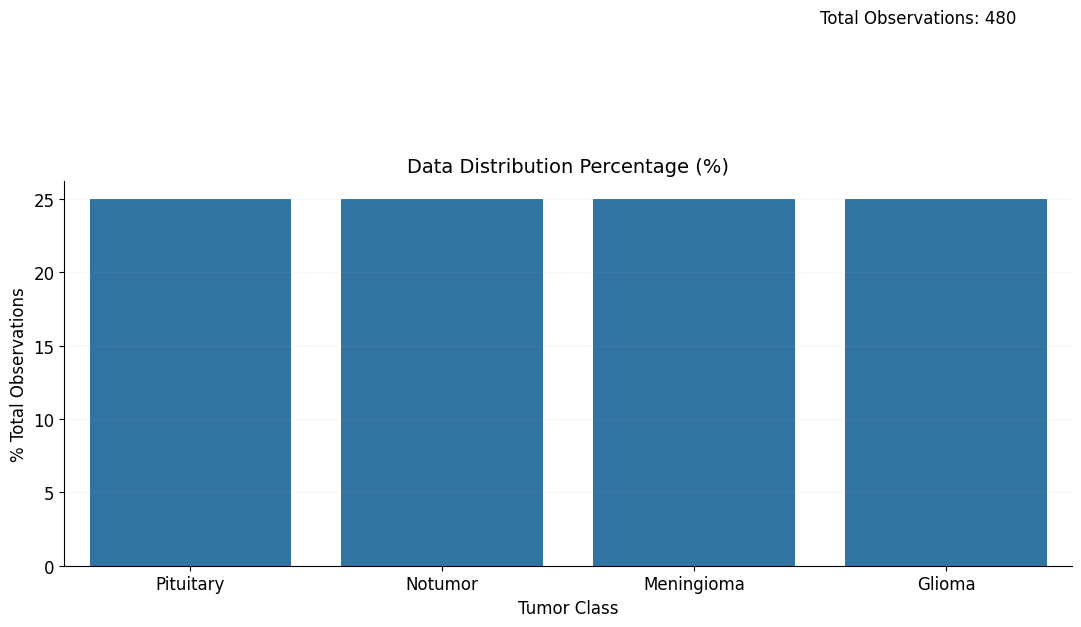

In [12]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

## Splitting the data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


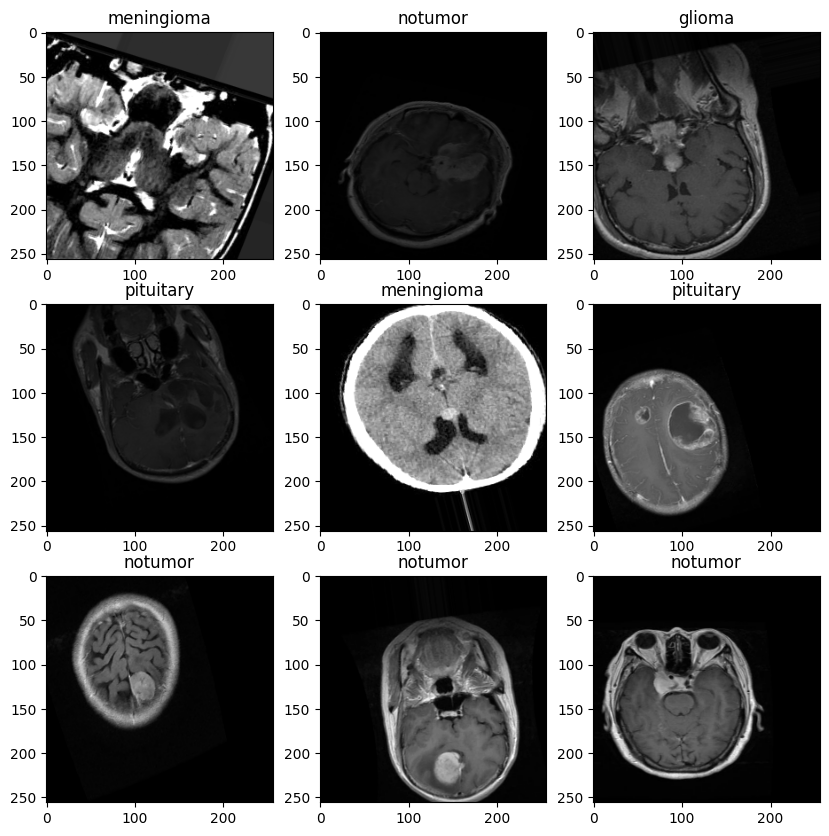

In [15]:
classes = os.listdir(dir)

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range = [0.3, 1.5],
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(256, 256),
    batch_size=batch_size,
    seed=42,
    subset='validation')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    seed=42,
    batch_size=batch_size
)

print(test_generator.class_indices)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        # Print Class
        plt.title(classes[np.argmax(Y_batch[0])])

        plt.imshow(image)
        break



# Training a u-net model

In [16]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Dense, Flatten
from keras.utils import plot_model

def create_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Downsampling (encoder)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    drop5 = Dropout(0.5)(conv5)

    # Upsampling (decoder)
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    # Output layer
    flatten = Flatten()(conv9)
    output = Dense(num_classes, activation='softmax')(flatten)

    model = Model(inputs=inputs, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Check if the model exists
if os.path.exists(model_file):
    # Load the model from the file
    model = load_model(model_file)
else:
    # Create a new model
    model = create_model((256, 256, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 128)        73856     ['max_pooling2d[0][0]']   

# Train the model

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
24/24 [==============================] - ETA: 0s - loss: 1.3860 - accuracy: 0.2500
Epoch 1: val_loss improved from inf to 1.37250, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 62s 1s/step - loss: 1.3860 - accuracy: 0.2500 - val_loss: 1.3725 - val_accuracy: 0.3021
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 1.3609 - accuracy: 0.2682
Epoch 2: val_loss improved from 1.37250 to 1.33817, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 21s 873ms/step - loss: 1.3609 - accuracy: 0.2682 - val_loss: 1.3382 - val_accuracy: 0.3542
Epoch 3/50
24/24 [==============================] - ETA: 0s - loss: 1.2745 - accuracy: 0.3698
Epoch 3: val_loss did not improve from 1.33817
24/24 [==============================] - 21s 851ms/step - loss: 1.2745 - accuracy: 0.3698 - val_loss: 1.4644 - val_accuracy: 0.3542
Epoch 4/50
24/24 [==============================] - ETA: 0s - loss: 1.2356 - acc

# Testing the Model

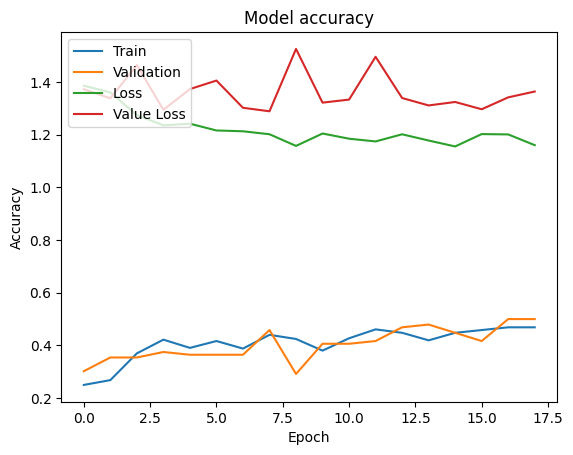

In [18]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

82/82 [==============================] - 17s 204ms/step


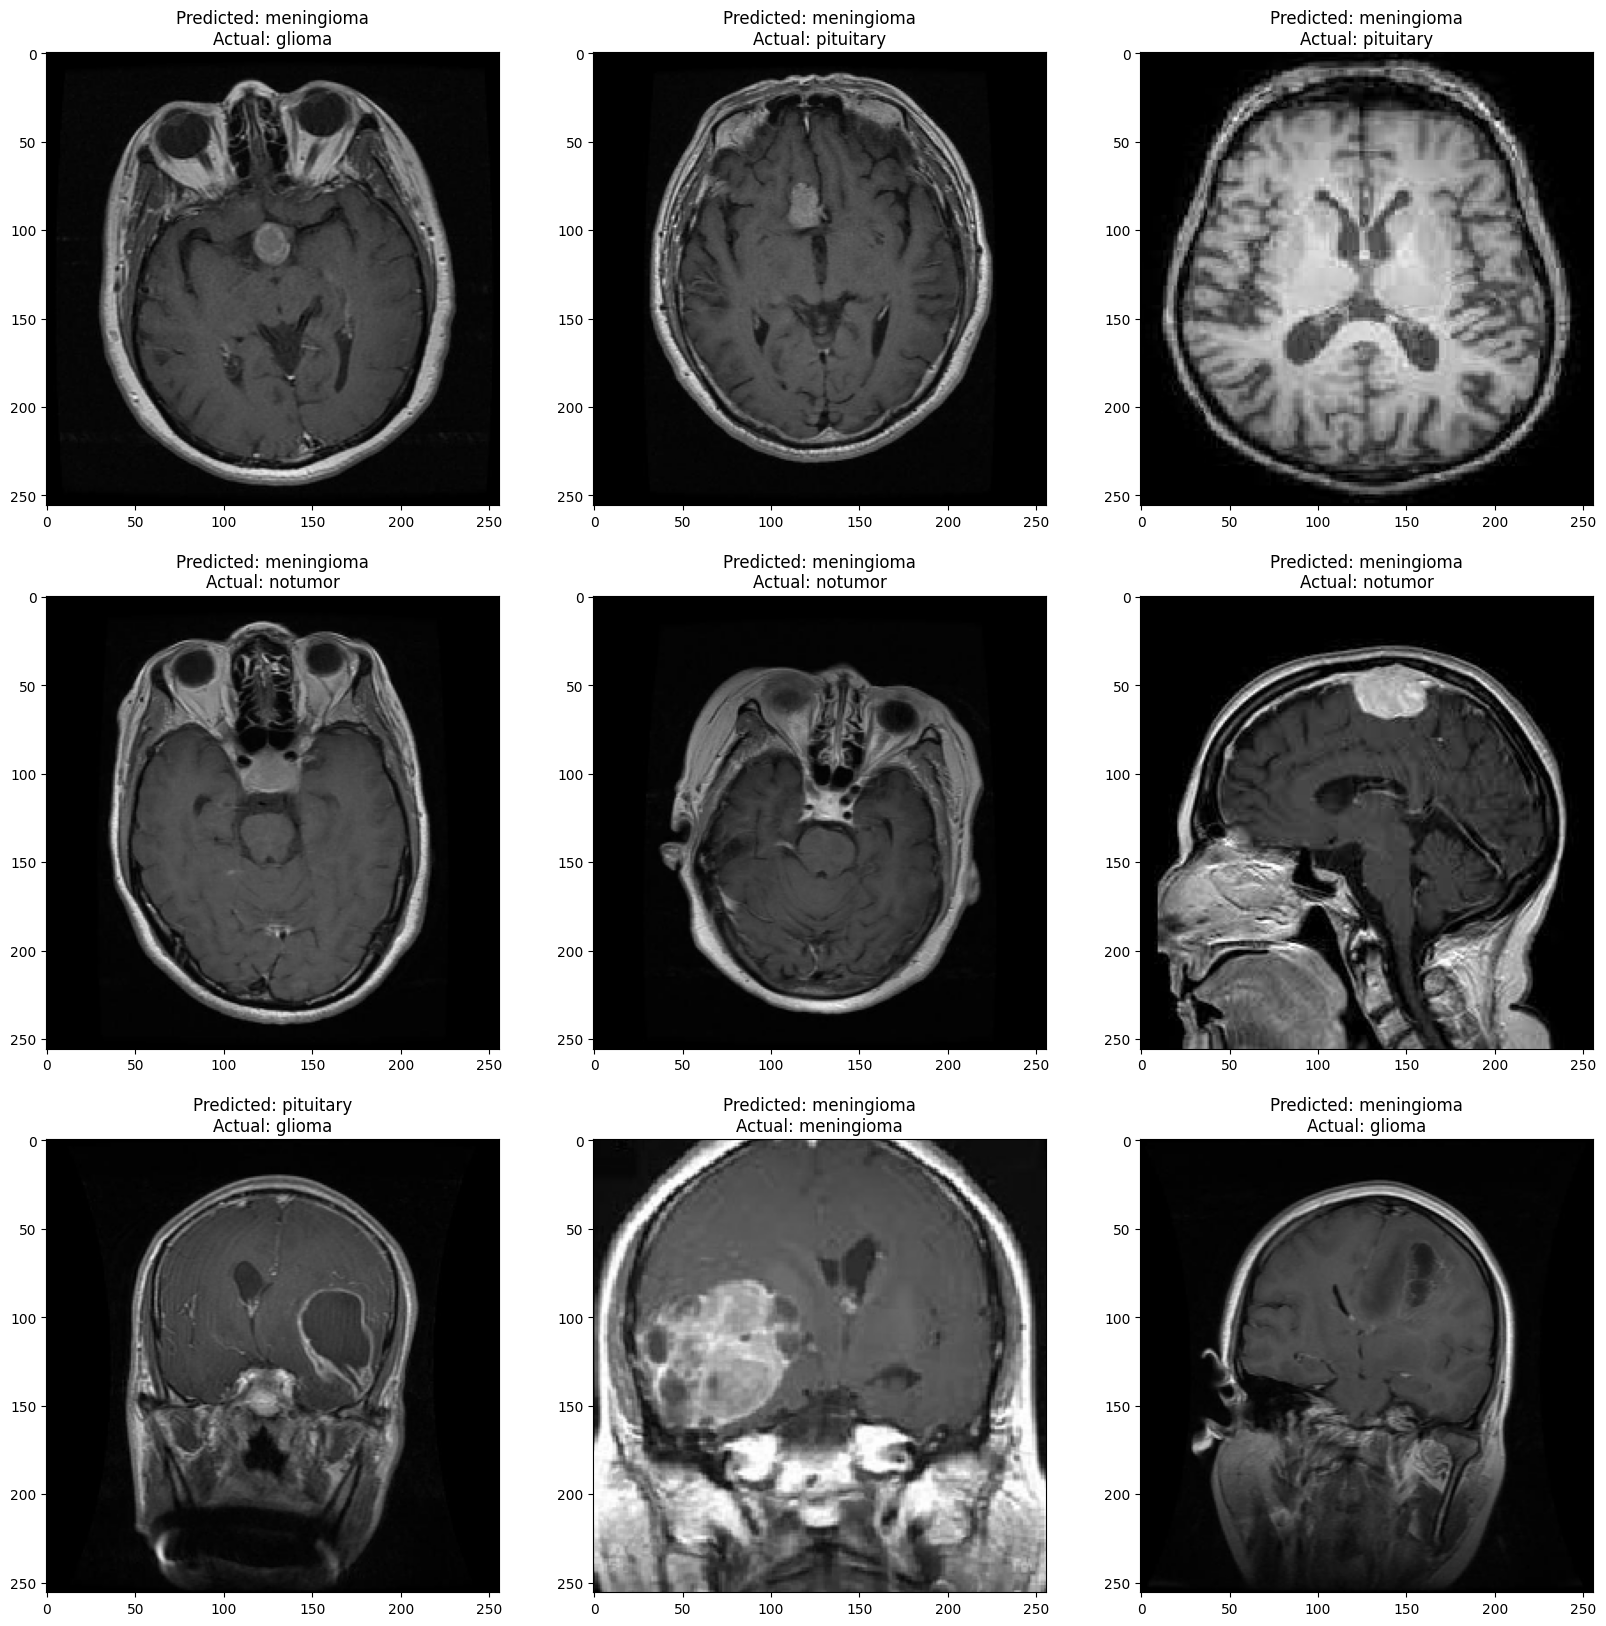

In [19]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(validation_generator)

# Predict the output
predictions = model.predict(validation_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in validation_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


# Model Visualisation (Evaluation)

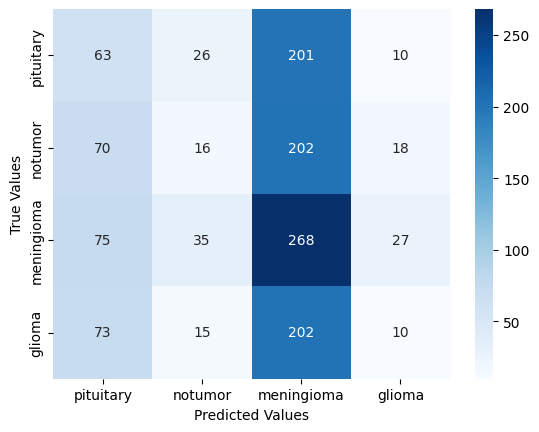

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(validation_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
